In [55]:
import warnings
warnings.filterwarnings("ignore")
import logging
from transformers import logging as tf_logging
tf_logging.set_verbosity_error()
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("PIL").setLevel(logging.ERROR)
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("datasets").setLevel(logging.ERROR)

In [56]:
!pip install --no-deps pycocotools seaborn sklearn transformers datasets


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [57]:
import os, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import FashionMNIST
from torchvision import transforms

from transformers import (
    DetrForObjectDetection,
    DetrImageProcessor,
    Trainer,
    TrainingArguments,
)
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import classification_report, confusion_matrix

# constants
MODEL_CHECKPOINT = "facebook/detr-resnet-50"
BATCH_SIZE       = 16
NUM_EPOCHS       = 5
LEARNING_RATE    = 1e-5
OUTPUT_DIR       = "./detr_fashionmnist"
os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
processor = DetrImageProcessor.from_pretrained(
    MODEL_CHECKPOINT,
    size={"shortest_edge":224, "longest_edge":224},
    do_resize=True
)
id2label = {i:str(i) for i in range(10)}
label2id = {v:int(v) for v in id2label.keys()}

In [59]:
class FashionDetectionDataset(Dataset):
    def __init__(self, train: bool):
        self.ds = FashionMNIST(root="./data", train=train, download=True)
        self.processor = processor

    def __len__(self): return len(self.ds)

    def __getitem__(self, idx):
        img_gray, label = self.ds[idx]
        img = transforms.ToPILImage()(transforms.ToTensor()(img_gray)).convert("RGB")
        w, h = img.size
        ann = [{"bbox":[0,0,w,h], "category_id":label, "area":w*h, "iscrowd":0}]
        gt = {"image_id": idx, "annotations": ann}
        enc = self.processor(images=img, annotations=gt, return_tensors="pt")
        return {
            "pixel_values": enc["pixel_values"].squeeze(0),
            "labels": enc["labels"][0],
        }

train_ds = FashionDetectionDataset(train=True)
val_ds   = FashionDetectionDataset(train=False)

In [60]:
def collate_fn(batch):
    pix = [x["pixel_values"] for x in batch]
    labs = [x["labels"] for x in batch]
    bat = processor.pad(pix, return_tensors="pt")
    bat["labels"] = labs
    return bat

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True, collate_fn=collate_fn
)


In [61]:
model = DetrForObjectDetection.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=10, id2label=id2label, label2id=label2id,
    ignore_mismatched_sizes=True
).to(device)

In [63]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    # evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir=f"{OUTPUT_DIR}/logs",
    fp16=True,
    disable_tqdm=False,
    report_to=[],
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor
)

In [64]:
train_results = trainer.train()
trainer.save_model(OUTPUT_DIR)


Step,Training Loss
3750,0.138800
7500,0.027500
11250,0.018500
15000,0.013500
18750,0.009800


All logged columns: ['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss']


,epoch,loss,val_loss
0,1.0,0.1388,NaN
1,2.0,0.0275,NaN
2,3.0,0.0185,NaN
3,4.0,0.0135,NaN
4,5.0,0.0098,NaN


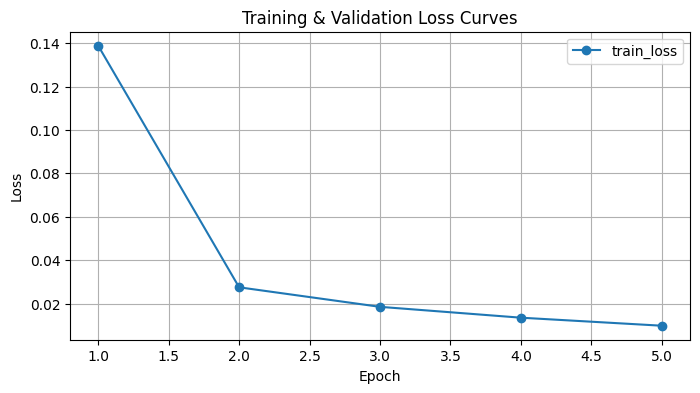

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)
print("All logged columns:", logs.columns.tolist())

train_logs = logs[
    logs["loss"].notna() & logs["epoch"].notna()
]

train_df = (
    train_logs.drop_duplicates("epoch", keep="first")
              .sort_values("epoch")
)[["epoch", "loss"]]

if "eval_loss" in logs.columns:
    eval_logs = logs[
        logs["eval_loss"].notna() & logs["epoch"].notna()
    ]
    eval_df = (
        eval_logs.drop_duplicates("epoch", keep="last")
                 .sort_values("epoch")
    )[["epoch", "eval_loss"]]
    eval_df = eval_df.rename(columns={"eval_loss": "val_loss"})
else:
    eval_df = pd.DataFrame({"epoch": [], "val_loss": []})

merged = pd.merge(train_df, eval_df, on="epoch", how="outer").sort_values("epoch")
display(merged)

plt.figure(figsize=(8,4))
plt.plot(merged["epoch"], merged["loss"],   marker="o", label="train_loss")
if not eval_df.empty:
    plt.plot(merged["epoch"], merged["val_loss"], marker="x", label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tqdm.auto import tqdm

images = [{"id": i, "height": 224, "width": 224} for i in range(len(val_ds))]
annotations = [{
    "id": i, "image_id": i,
    "category_id": int(val_ds.ds[i][1]),
    "bbox": [0, 0, 224, 224], "area": 224*224, "iscrowd": 0
} for i in range(len(val_ds))]
gt = {
    "images": images,
    "annotations": annotations,
    "categories": [{"id": i, "name": str(i)} for i in range(10)]
}
with open("val_gt.json", "w") as f:
    json.dump(gt, f)

preds = []
model.eval()
counter = 0
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Inference"):
        #movve to GPU
        pixels = batch["pixel_values"].to(device)
        mask   = batch.get("pixel_mask")
        if mask is not None:
            mask = mask.to(device)

        outputs = model(pixel_values=pixels, pixel_mask=mask)

        #post-processing in batches
        target_sizes = [(224, 224)] * pixels.shape[0]
        results = processor.post_process_object_detection(
            outputs,
            threshold=0.5,
            target_sizes=target_sizes
        )

        # Collect per-image preds
        for i, res in enumerate(results):
            image_id = counter + i
            for score, lab, box in zip(res["scores"], res["labels"], res["boxes"]):
                preds.append({
                    "image_id": image_id,
                    "category_id": int(lab),
                    "bbox": [float(x) for x in box],
                    "score": float(score)
                })
        counter += pixels.shape[0]

# 3) Save predictions
with open("val_preds.json", "w") as f:
    json.dump(preds, f)

print(f"Collected {len(preds)} total detections on {counter} images.")


Inference:   0%|          | 0/625 [00:00<?, ?it/s]

Collected 9946 total detections on 10000 images.


In [77]:
coco_gt = COCO("val_gt.json")
coco_dt = coco_gt.loadRes("val_preds.json")
ce = COCOeval(coco_gt, coco_dt, "bbox")
ce.evaluate(); ce.accumulate(); ce.summarize()
map50_95 = ce.stats[0]

# classification accuracy & mCIoU
# best‐pred per image
best_preds = {}
for p in preds:
    i = p["image_id"]
    if i not in best_preds or p["score"]>best_preds[i]["score"]:
        best_preds[i] = p

# classification accuracy
y_true = [val_ds.ds[i][1] for i in range(len(val_ds))]
y_pred = [best_preds[i]["category_id"] if i in best_preds else -1 for i in range(len(val_ds))]
correct = sum(1 for gt,p in zip(y_true,y_pred) if gt==p)
cAcc = correct/len(y_true)

# mCIoU
ious = {i:[] for i in range(10)}
for p in preds:
    gt = np.array([0,0,224,224])
    pr = np.array(p["bbox"])
    xA,yA = max(gt[0],pr[0]), max(gt[1],pr[1])
    xB,yB = min(gt[0]+gt[2],pr[0]+pr[2]), min(gt[1]+gt[3],pr[1]+pr[3])
    inter = max(0,xB-xA)*max(0,yB-yA)
    union = 224*224 + pr[2]*pr[3] - inter
    iou = inter/union if union>0 else 0
    ious[p["category_id"]].append(iou)
mCIoU = np.mean([np.mean(v) if v else 0 for v in ious.values()])

# print metrics
print(f"\nmAP @[0.50:0.95]:      {map50_95:.4f}")
print(f"Classification Acc:   {cAcc:.4f}")
print(f"Mean Class IoU:       {mCIoU:.4f}\n")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.19s).
Accumulating evaluation results...
DONE (t=11.28s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.929
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.929
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.929
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.929
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.941
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.941
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

,precision,recall,f1-score,support
T-shirt,0.887897,0.895,0.891434,1000.0
Trouser,0.997984,0.990,0.993976,1000.0
Pullover,0.937247,0.926,0.931590,1000.0
Dress,0.951318,0.938,0.944612,1000.0
Coat,0.913001,0.934,0.923381,1000.0
Sandal,0.989044,0.993,0.991018,1000.0
Shirt,0.845251,0.792,0.817759,1000.0
Sneaker,0.968317,0.978,0.973134,1000.0
Bag,0.982249,0.996,0.989076,1000.0
Ankle boot,0.983740,0.968,0.975806,1000.0


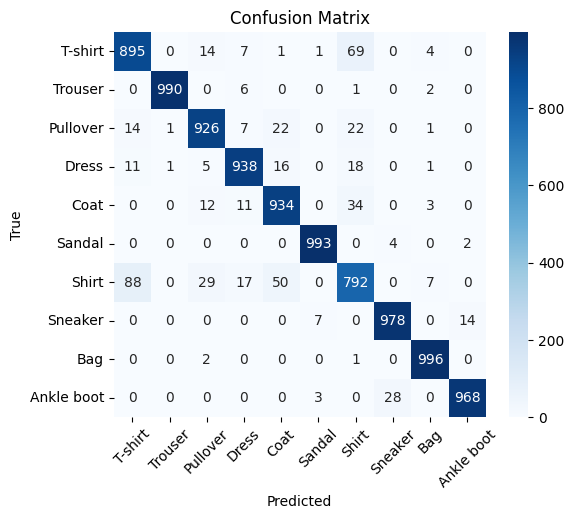

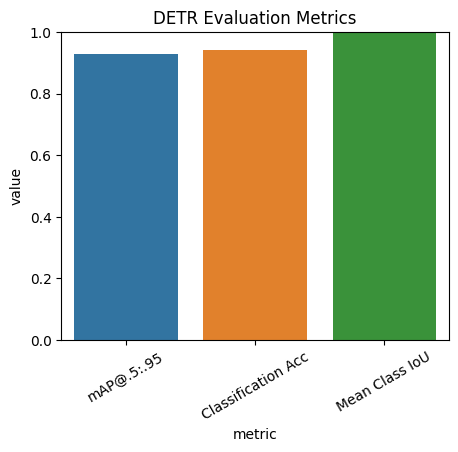

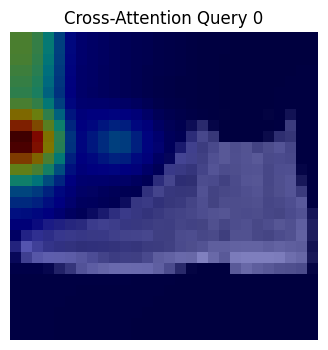

In [ ]:
target_names = [
    "T-shirt", "Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]
report = classification_report(
    y_true, y_pred, labels=list(range(10)),
    target_names=target_names, output_dict=True
)
df_report = pd.DataFrame(report).T
display(df_report)

cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.show()

df_met = pd.DataFrame({
    "metric": ["mAP@.5:.95","Classification Acc","Mean Class IoU"],
    "value": [map50_95, cAcc, mCIoU]
})
plt.figure(figsize=(5,4))
sns.barplot(x="metric", y="value", data=df_met)
plt.ylim(0,1); plt.xticks(rotation=30)
plt.title("DETR Evaluation Metrics")
plt.show()

model.config.output_attentions = True
img_gray, _ = val_ds.ds[0]
img = transforms.ToPILImage()(transforms.ToTensor()(img_gray)).convert("RGB")
enc = processor(images=img, return_tensors="pt").to(device)
with torch.no_grad():
    out = model(**enc, output_attentions=True)
attn = out.cross_attentions[-1][0]  
avg = attn.mean(0)[0]               
H = W = int(np.sqrt(avg.shape[-1]))
heat = avg.reshape(H, W).cpu().numpy()
import cv2
hm = cv2.resize(heat, img.size)
plt.figure(figsize=(4,4))
plt.imshow(img); plt.imshow(hm, alpha=0.5, cmap="jet")
plt.axis("off"); plt.title("Cross-Attention Query 0")
plt.show()

In [ ]:
fashion_labels = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]
id2label = {i: name for i, name in enumerate(fashion_labels)}
label2id = {name: i for i, name in enumerate(fashion_labels)}


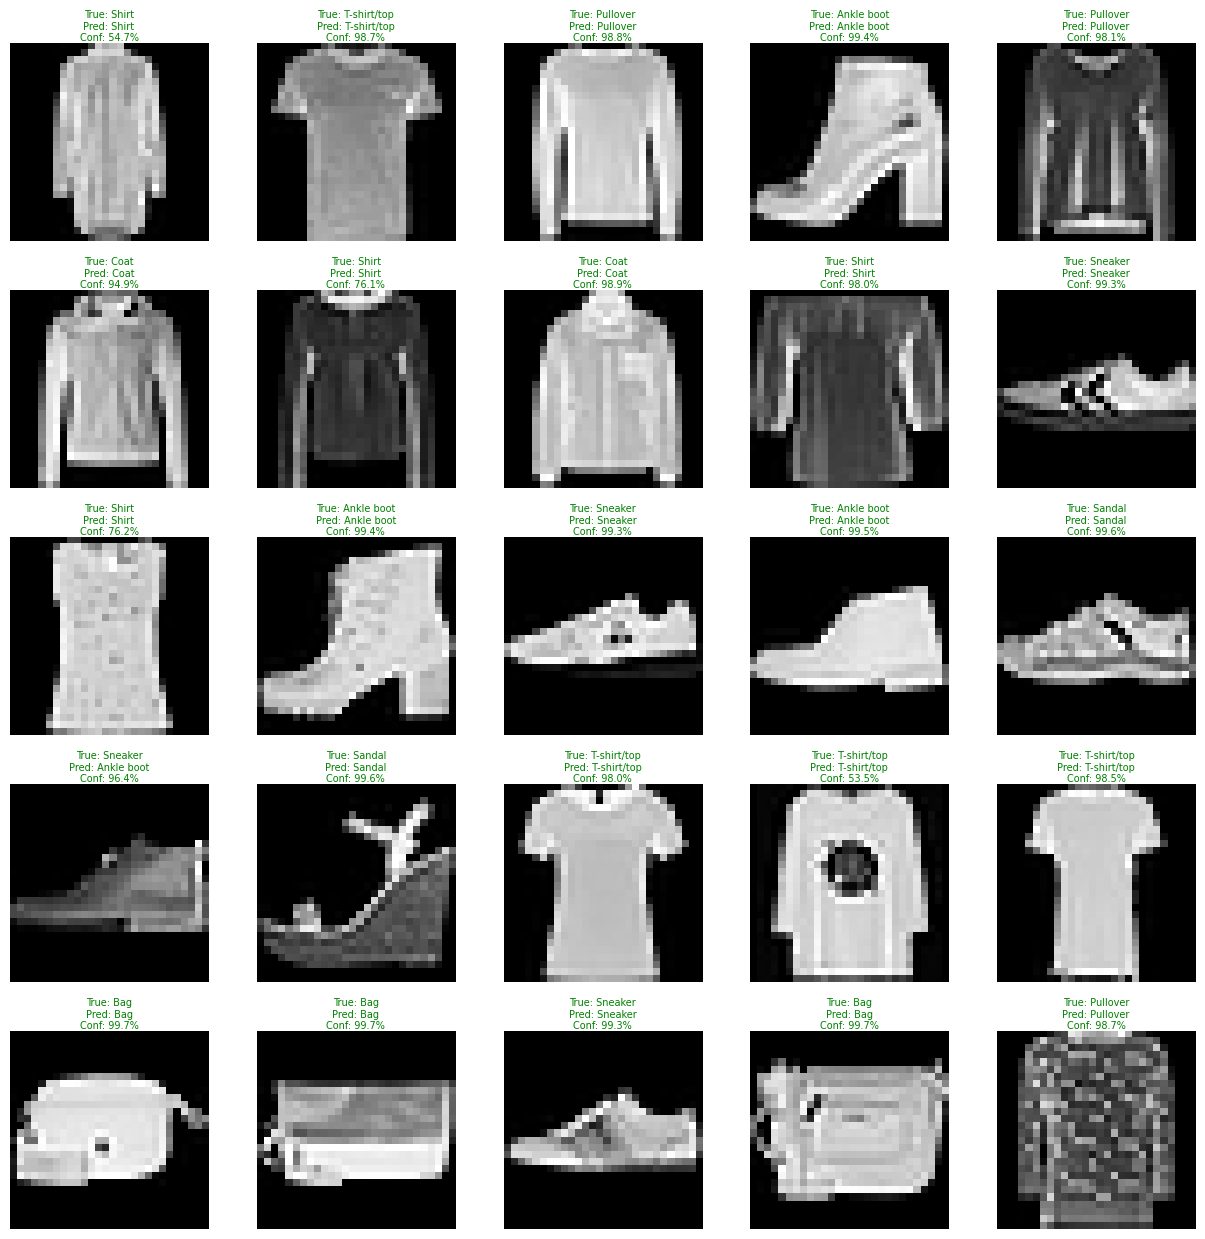

In [ ]:
import matplotlib.pyplot as plt
import random
from torchvision import transforms

n_samples = 25
cols = 5
rows = (n_samples + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
axes = axes.flatten()

for ax in axes[:n_samples]:
    idx = random.randrange(len(val_ds))
    img_gray, gt_label = val_ds.ds[idx]
    img = transforms.ToPILImage()(transforms.ToTensor()(img_gray)).convert("RGB")
    
    # DETR inference
    enc = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**enc)
    res = processor.post_process_object_detection(out, threshold=0.05, target_sizes=[img.size])[0]
    
    # pick best prediction
    if len(res["scores"]) > 0:
        i = res["scores"].argmax().item()
        pred_label = int(res["labels"][i])
        conf = res["scores"][i].item() * 100
    else:
        pred_label, conf = None, 0.0

    ax.imshow(img)
    ax.axis("off")
    # title with real names
    true_name = id2label[gt_label]
    pred_name = id2label[pred_label] if pred_label is not None else "–"
    ax.set_title(f"True: {true_name}\nPred: {pred_name}\nConf: {conf:.1f}%",
                 fontsize=7, color="green", pad=2)

# hide extras
for ax in axes[n_samples:]:
    ax.axis("off")

plt.tight_layout()
plt.show()
